<a href="https://colab.research.google.com/github/YonatanEisenstein/Gold-Mining-Process-Optimization/blob/main/Gold_Mining_Optimization_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrated Project 3 - Gold Mining

In this Project I will prepare a prototype of a machine learning model for Zyfra. Zyfra is a company that develops efficiency solutions for heavy industry.

In this task the model should predict the amount of gold recovered from gold ore. The model will help to optimize the production and eliminate unprofitable parameters.

## Data Set Description 

The gold processing process includes 4 stages: floatation, primary purification, secondary purification, and final concentration (In each of the stages we have input and output, and in the output we have the product and the trash). So each feature name includes stage name which is:
 - rougher — flotation
 - primary_cleaner — primary purification
 - secondary_cleaner — secondary purification
 - final — final characteristics

In addition, each feature name includes parameter type, which could take values as:
 - input — raw material parameters
 - output — product parameters
 - state — parameters characterizing the current state of the stage
 - calculation — calculation characteristics

In the end of the feature name the parameter name itself appear. The names include values such as:
 - air amount — volume of air
 - fluid levels
 - feed size — feed particle size
 - feed rate


So, each feature name looks as follows:

[stage].[parameter_type].[parameter_name].

For Example: rougher.input.feed_ag

Material Symbols:
 - au: Gold
 - ag: Silver
 - pb: Polybutylene
 - sol: Colloid
 - sulfate

The Data Set includes 3 files: train, test and full source. There is features that do not include in the test. So we will need to drop them from the train also when prepare the data for modeling.

## The Task

Our task is to build a model that predicts the gold recovery after floatation and in the final stage. In order to clarify the task bit more, here is the scheme of the purification process:

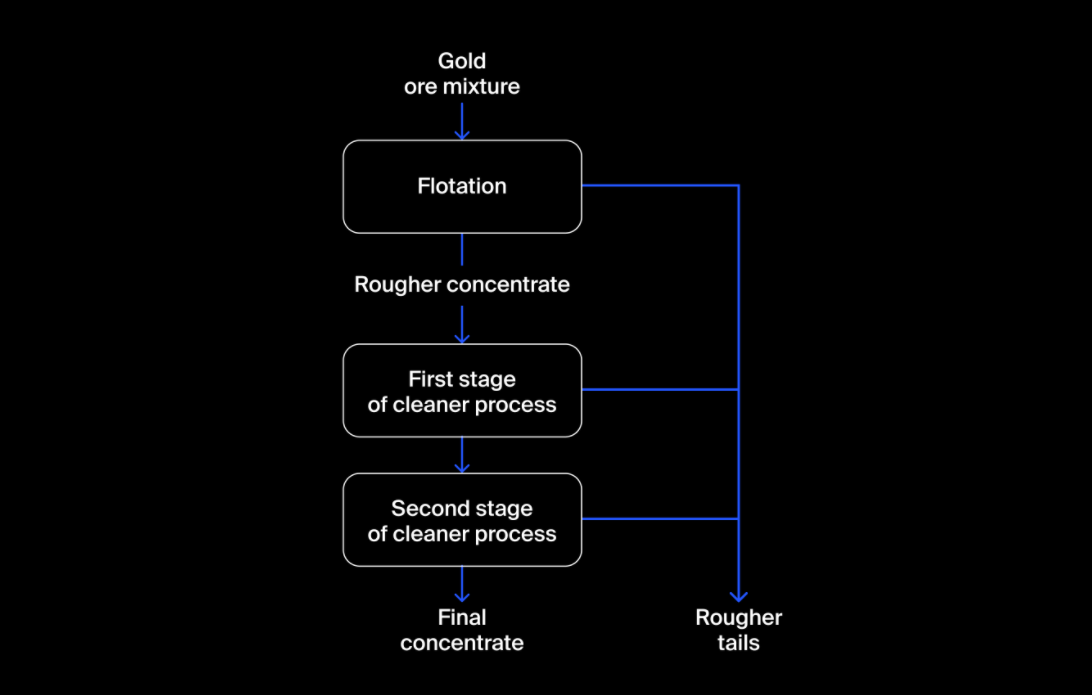

Our goal in this task is to predict recovery rates in the rougher and final concentrates. Recovery rates is a measure of the purification quality (The exact formula for calculating recovery will be presented later). If we can predict recovery rates, we can optimize the purification process, since the company Chemists can approximate the quality of the purification stages with different amounts of the various parameter *before* actually execute the purification. This can be incredibly profitable for the company.

## Import the Data and Compare test-train-full data sets 

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import plotly.express as px
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_train = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_train.csv")
data_test = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_test.csv")
data_full = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_full.csv")

In [5]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,20.050975,86.843261,

In [6]:
display(data_train.shape)
display(data_test.shape)
display(data_full.shape)

(16860, 87)

(5856, 53)

(22716, 87)

In [7]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


The only columns without missing values is date. Lets check number of unique dates

In [8]:
data_full['date'].nunique()

22716

Yes, there is no 2 duplicates dates, so the date is a unique identifier of each row. Now lets check the data test info.

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

First thing to note is the differences between the sets. When comparing full dataset with test dataset we can see that in the test there are 87-53 = 34 luck features. This features are the output type features and the calculation type features. Lets check that explicitly:

In [10]:
# check what features are not found in the test set

not_in_test = []

for i in data_full.columns:
  found = 0
  for j in data_test.columns:
    if i == j:
      found = 1
  if (found == 0):
    not_in_test.append(i)

display(not_in_test)
print()
print("Number of columns not in test set:", len(not_in_test))

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta


Number of columns not in test set: 34


Well, as expected, Output and calculation parameters types are not part of the test set.

Now what I want to do is to check if the calculations in the full data set ate done right. I will check the "rougher.output.recovery" by calculate it then compare it to the value found on the table. I will use the training set for that. 

In [11]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,20.050975,86.843261,

The formula to calculate recovery is this:

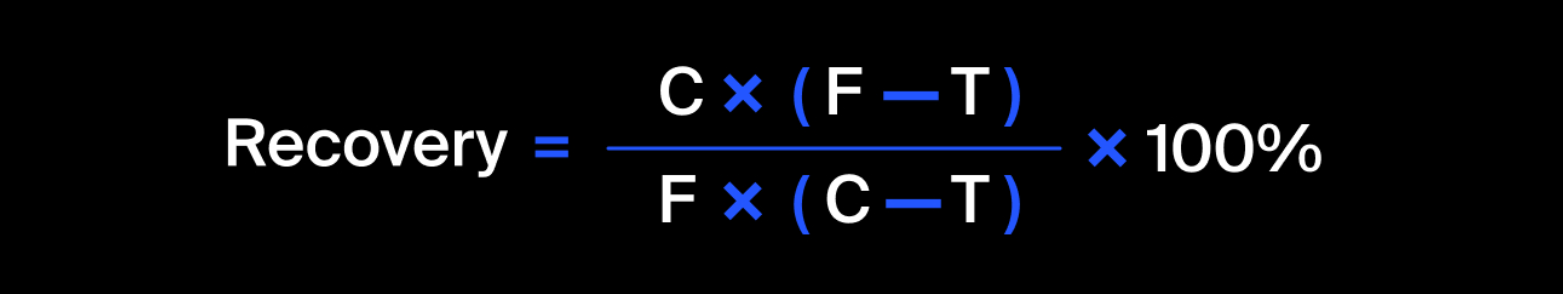

Where C is the share of gold after floatation, F is share of gold before floatation and T is share of gold in tale (trash) after floatation. Lets write a function to calculate this value

In [12]:
def rougher_recovery_calculation (row):

  rougher_recovery = 0
  if (row['rougher.input.feed_au'] * (row['rougher.output.concentrate_au'] - row['rougher.output.tail_au']) != 0):
    rougher_recovery = (row['rougher.output.concentrate_au'] * (row['rougher.input.feed_au'] - row['rougher.output.tail_au'])) / (row['rougher.input.feed_au'] * (row['rougher.output.concentrate_au'] - row['rougher.output.tail_au']))
    rougher_recovery = rougher_recovery * 100
  return rougher_recovery

In [13]:
data_train['rougher.output.recovery.calculated'] = data_train.apply(rougher_recovery_calculation, axis=1)

In [14]:
display(data_train['rougher.output.recovery'].shape)
display(data_train['rougher.output.recovery.calculated'].shape)

(16860,)

(16860,)

Now I can calculate the MAE between the original values and the values I calculated

In [15]:
df = data_train[['rougher.output.recovery', 'rougher.output.recovery.calculated']]
display(df.isnull().sum())
df = df.dropna()

rougher.output.recovery               2573
rougher.output.recovery.calculated    2250
dtype: int64

In [16]:
# Check if thre is values that missing in calculated column but not missing in original column 

len(df[(df['rougher.output.recovery'].isnull()) & (df['rougher.output.recovery.calculated'].isnull() == False)])

0

Well, There is no values that missed in calculated column, but not missed in original column.

In [17]:
df.head()

,rougher.output.recovery,rougher.output.recovery.calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [18]:
mean_absolute_error(df['rougher.output.recovery'], df['rougher.output.recovery.calculated'])

9.444891926100695e-15

Cool! As we can see the error is very very small. So we can conclude that the rougher.output.recovery that originaly found in the data is correctly calculated. So we can drop the new column that we created.

And Lets move to data pre-processing

## Data Pre-Processing

In [19]:
data_full.isnull().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

There is some null values in the data set. I want to check the amount of nulls in percentages.

In [20]:
percent_missing = data_full.isnull().sum() * 100 / len(data_full)
percent_missing

date                                          0.000000
final.output.concentrate_ag                   0.391794
final.output.concentrate_pb                   0.382990
final.output.concentrate_sol                  1.694841
final.output.concentrate_au                   0.378588
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.444621
secondary_cleaner.state.floatbank5_b_air      0.444621
secondary_cleaner.state.floatbank5_b_level    0.440218
secondary_cleaner.state.floatbank6_a_air      0.523860
secondary_cleaner.state.floatbank6_a_level    0.444621
Length: 87, dtype: float64

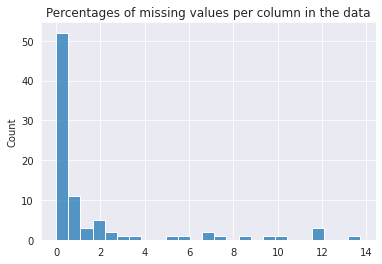

In [21]:
sns.set_style("darkgrid")
sns.histplot(percent_missing, bins=25)
plt.title("Percentages of missing values per column in the data")
plt.show()

There is some columns with high percentage of null values. Lets check how much missing values there is in the target variables. 

In [22]:
print(data_full['final.output.recovery'].isnull().sum())
print(data_full['rougher.output.recovery'].isnull().sum())

1963
3119


This values cannot be fill with other features (since if we do that the model will be influenced from that filling). So I will drop the raws with null in the target variable. 

In [23]:
data_full_filt = data_full.dropna(subset=['final.output.recovery', 'rougher.output.recovery'])

In [24]:
data_full_filt.isnull().sum().sample(10)

rougher.output.tail_au                         0
secondary_cleaner.state.floatbank3_b_level     1
rougher.input.floatbank10_sulfate             34
rougher.state.floatbank10_a_level              1
rougher.state.floatbank10_b_level              1
primary_cleaner.state.floatbank8_c_level       1
primary_cleaner.state.floatbank8_d_air         3
date                                           0
primary_cleaner.output.tail_pb                21
secondary_cleaner.state.floatbank4_a_level     1
dtype: int64

In [25]:
percent_missing = data_full_filt.isnull().sum() * 100 / len(data_full_filt)
percent_missing

date                                          0.000000
final.output.concentrate_ag                   0.005144
final.output.concentrate_pb                   0.005144
final.output.concentrate_sol                  1.085447
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.005144
secondary_cleaner.state.floatbank5_b_air      0.005144
secondary_cleaner.state.floatbank5_b_level    0.005144
secondary_cleaner.state.floatbank6_a_air      0.010289
secondary_cleaner.state.floatbank6_a_level    0.005144
Length: 87, dtype: float64

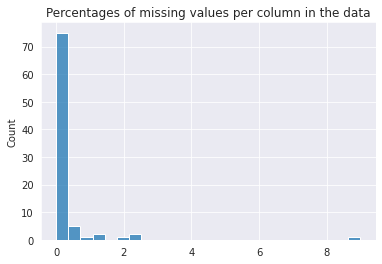

In [26]:
sns.histplot(percent_missing, bins=25)
plt.title("Percentages of missing values per column in the data")
plt.show()

Who is the column with 12% of missing values?

In [27]:
percent_missing[percent_missing.iloc[:] > 10]

Series([], dtype: float64)

Output tail of secondary cleaner is not part of the test set. So it can not take part in model's training and predicting. I can drop this column.

In [28]:
data_full_filt = data_full_filt.drop(['secondary_cleaner.output.tail_sol'], axis=1)

In [29]:
percent_missing = data_full_filt.isnull().sum() * 100 / len(data_full_filt)
percent_missing

date                                          0.000000
final.output.concentrate_ag                   0.005144
final.output.concentrate_pb                   0.005144
final.output.concentrate_sol                  1.085447
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.005144
secondary_cleaner.state.floatbank5_b_air      0.005144
secondary_cleaner.state.floatbank5_b_level    0.005144
secondary_cleaner.state.floatbank6_a_air      0.010289
secondary_cleaner.state.floatbank6_a_level    0.005144
Length: 86, dtype: float64

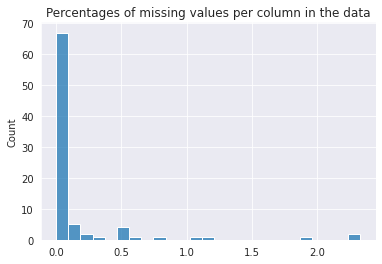

In [30]:
sns.histplot(percent_missing, bins=25)
plt.title("Percentages of missing values per column in the data")
plt.show()

Well, Now the number of missing values is amaller. What could be done in regard with the rest of missing values? As we can see, the rows are orderd in time series. So, it could be the case that each row values are closed to the previous one. Lets check this conjecture in one of the columns. In order to do that I will compare to graphs: one in which rows are orderd according to time, and the second in which random sample of rows will be taken.

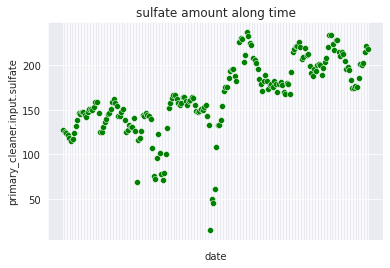

In [31]:
# rows orderd with time series

sns.set_style()
g = sns.scatterplot(x=data_full_filt['date'].head(200), y=data_full_filt['primary_cleaner.input.sulfate'].head(200), color='green')
g.set(xticklabels=[])
plt.title("sulfate amount along time")
plt.show()

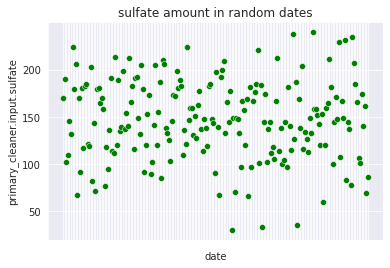

In [32]:
# random sample of rows

g = sns.scatterplot(x=data_full_filt['date'].sample(200, random_state=1),
                    y=data_full_filt['primary_cleaner.input.sulfate'].sample(200, random_state=1), color='green')
g.set(xticklabels=[])
plt.title("sulfate amount in random dates")
plt.show()

Cool! we can see from the above illustration that, in general, close values in terms of date are closed to each other. However, there is cases in which there is gaps between closed dates. So I think the best way to solved this is to use "rolling mean". Using this method I fill missing values with the moving average of the last 10 dates.

In [33]:
# method to fill null values with the moveing average
data_full_filt = data_full_filt.fillna(data_full_filt.rolling(20, min_periods=1).mean())

In [34]:
data_full_filt.isnull().sum()[data_full_filt.isnull().sum() > 0]

final.output.tail_pb                         16
rougher.input.feed_pb                        13
rougher.input.feed_size                      70
rougher.input.floatbank11_xanthate          255
rougher.state.floatbank10_e_air             329
secondary_cleaner.state.floatbank2_a_air     81
dtype: int64

We still have null values, probably since there is cases in which there is more than 20 missing values in sequence. So what i will do is to run this proces in series sevaral time, so that we can use filling values, in order to fill other values.

In [35]:
for i in range(15):
  data_full_filt = data_full_filt.fillna(data_full_filt.rolling(20, min_periods=1).mean())

In [36]:
data_full_filt.isnull().sum()[data_full_filt.isnull().sum() > 0]

Series([], dtype: int64)

Yeh, all missiing values are filled up. Now I will check duplicates and convert date to datetime Dtype

In [37]:
data_full_filt.duplicated().sum()

0

In [38]:
data_full_filt['date'] = pd.to_datetime(data_full_filt['date'])

And now we can check our work

In [39]:
data_full_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19439 entries, 0 to 22715
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19439 non-null  float64       
 2   final.output.concentrate_pb                         19439 non-null  float64       
 3   final.output.concentrate_sol                        19439 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19439 non-null  float64       
 7   final.output.tail_pb                                19439 non-null  float64       
 8   final.

Very Good! Lets do the same process with train and test sets

In [40]:
data_train_filt = data_train.dropna(subset=['final.output.recovery', 'rougher.output.recovery'])
data_train_filt = data_train_filt.drop(['secondary_cleaner.output.tail_sol'], axis=1)
for i in range(15):
  data_train_filt = data_train_filt.fillna(data_train_filt.rolling(20, min_periods=1).mean())
data_train_filt['date'] = pd.to_datetime(data_train_filt['date'])
data_train_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14149 non-null  float64       
 2   final.output.concentrate_pb                         14149 non-null  float64       
 3   final.output.concentrate_sol                        14149 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14149 non-null  float64       
 8   final.

In test set we do not have all the .output columns. So lets check amount of missing values for the other columns.

In [41]:
percent_missing = data_test.isnull().sum() * 100 / len(data_test)
percent_missing

date                                          0.000000
primary_cleaner.input.sulfate                 5.157104
primary_cleaner.input.depressant              4.849727
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                2.834699
primary_cleaner.state.floatbank8_a_air        0.273224
primary_cleaner.state.floatbank8_a_level      0.273224
primary_cleaner.state.floatbank8_b_air        0.273224
primary_cleaner.state.floatbank8_b_level      0.273224
primary_cleaner.state.floatbank8_c_air        0.273224
primary_cleaner.state.floatbank8_c_level      0.273224
primary_cleaner.state.floatbank8_d_air        0.273224
primary_cleaner.state.floatbank8_d_level      0.273224
rougher.input.feed_ag                         0.273224
rougher.input.feed_pb                         0.273224
rougher.input.feed_rate                       0.683060
rougher.input.feed_size                       0.375683
rougher.input.feed_sol                        1.144126
rougher.in

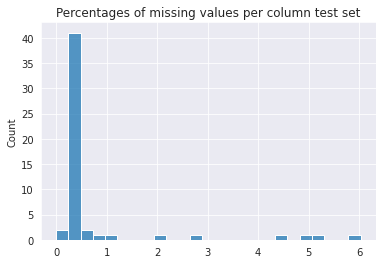

In [42]:
sns.set_style("darkgrid")
sns.histplot(percent_missing, bins=25)
plt.title("Percentages of missing values per column test set")
plt.show()

There is some amount of missing values here. I will fill them also using the moving average. But in order to do that we have to check that also in test set, close rows are close in their values.

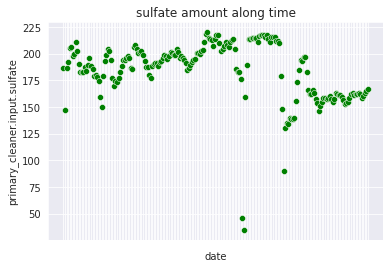

In [43]:
sns.set_style()
g = sns.scatterplot(x=data_test['date'][1000:1200], y=data_test['primary_cleaner.input.sulfate'][1000:1200], color='green')
g.set(xticklabels=[])
plt.title("sulfate amount along time")
plt.show()

Yes, so here too I can fill up the missing values using the same method as before.

In [44]:
for i in range(15):
  data_test = data_test.fillna(data_test.rolling(20, min_periods=1).mean())
data_test['date'] = pd.to_datetime(data_test['date'])
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float64       
 2   primary_cleaner.input.depressant            5856 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5856 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64       
 9   primary_

Great, so we complete the pre processing. Time to move to EDA. 

## Exploratory Data Analysis and Outliers Detection.

First thing to looking for is how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [45]:
Au_concentrations = data_full_filt[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
Ag_concentrations = data_full_filt[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
Pb_concentrations = data_full_filt[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]

concentrations = {'Au_concentrations': Au_concentrations, 'Ag_concentrations': Ag_concentrations, 'Pb_concentrations': Pb_concentrations}

In [46]:
display(Au_concentrations.mean())
print()
display(Ag_concentrations.mean())
print()
display(Pb_concentrations.mean())

rougher.input.feed_au                     8.266097
rougher.output.concentrate_au            19.772000
primary_cleaner.output.concentrate_au    32.119400
final.output.concentrate_au              44.076513
dtype: float64

rougher.input.feed_ag                     8.794927
rougher.output.concentrate_ag            11.994759
primary_cleaner.output.concentrate_ag     8.442408
final.output.concentrate_ag               5.168411
dtype: float64

rougher.input.feed_pb                    3.589682
rougher.output.concentrate_pb            7.606272
primary_cleaner.output.concentrate_pb    9.821348
final.output.concentrate_pb              9.978865
dtype: float64

Lets plot this results using plotly

In [47]:
for c in concentrations:

  fig = go.Figure(go.Funnel(
      x = concentrations[c].mean()
      ))
  
  fig.update_layout(
    title={
        'text': "{} for each stage of the process".format(c),
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
  
  fig.show()

What we can see is that as we go forward in the process, Gold concentration increased, Pb concentration increased and Silver concentration increased then decreased.

Now I want to compare the feed particle size distributions in the training and test sets since if the distributions vary significantly, the model evaluation will be incorrect.

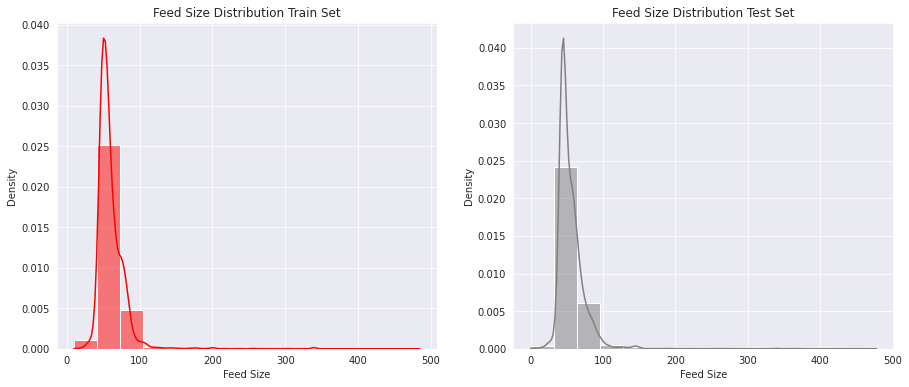

In [48]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.histplot(data_train_filt['rougher.input.feed_size'],
             bins=15, ax=ax[0],
             stat='density',
             color='red',
             kde=True)
ax[0].set_title("Feed Size Distribution Train Set")
ax[0].set_xlabel("Feed Size")
sns.histplot(data_test['rougher.input.feed_size'],
             bins=15,
             ax=ax[1],
             stat='density',
             color='gray',
             kde=True)
ax[1].set_title("Feed Size Distribution Test Set")
ax[1].set_xlabel("Feed Size")
plt.show()

The 2 distributions seems quite the same. Lets do a statistical test. Since the distributions are not normal I will use the Mann-Whithney non-parametric test.

In [49]:
results = st.mannwhitneyu(data_train_filt['rougher.input.feed_size'],
                      data_test['rougher.input.feed_size'])

print('p-value: ', results[1])

p-value:  3.9527032437855205e-141


We get a tiny pvalue. So allegedly we have to conclude that the two samples are different, statisticaly speaking. Lets check for outliers and filter them out. Then execute the test again.

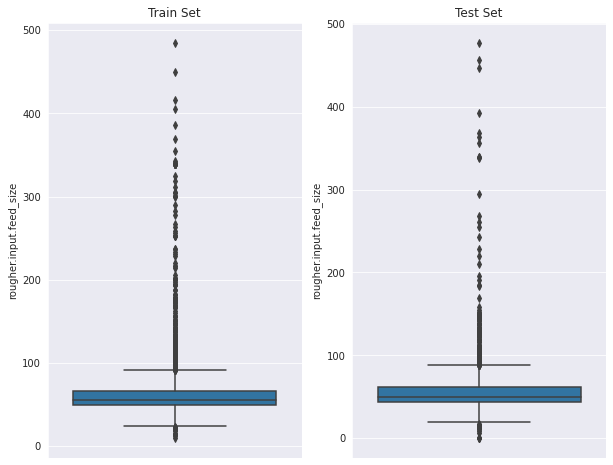

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10,8))
sns.boxplot(data=data_train_filt, y='rougher.input.feed_size', ax=ax[0])
sns.boxplot(data=data_test, y='rougher.input.feed_size', ax=ax[1])
ax[0].set_title("Train Set")
ax[1].set_title("Test Set")
plt.show()

We have outliers in the data. I will filter out values that higher than 100, and execute the test again. To begin with, I will draw the density distributions when outliers removed.

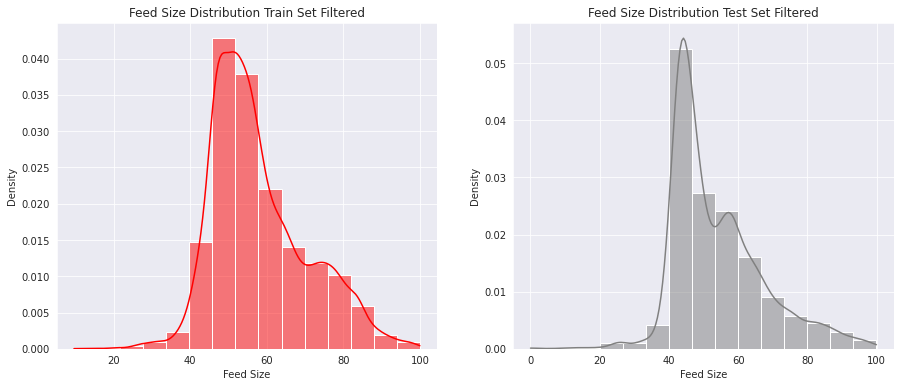

In [51]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.histplot(data_train_filt[data_train_filt['rougher.input.feed_size']<100]['rougher.input.feed_size'],  #remove values higher than 100
             bins=15,
             ax=ax[0],
             stat='density',
             color='red',
             kde=True)
ax[0].set_title("Feed Size Distribution Train Set Filtered")
ax[0].set_xlabel("Feed Size")
sns.histplot(data_test[data_test['rougher.input.feed_size']<100]['rougher.input.feed_size'],
             bins=15,
             ax=ax[1],
             stat='density',
             color='gray',
             kde=True)
ax[1].set_title("Feed Size Distribution Test Set Filtered")
ax[1].set_xlabel("Feed Size")
plt.show()

Well, the distributions seems similar, but not exactly the same. Lets conduct the statistical test.

In [52]:
results = st.mannwhitneyu(data_train_filt[data_train_filt['rougher.input.feed_size'] < 100]['rougher.input.feed_size'],
                      data_test[data_test['rougher.input.feed_size'] < 100]['rougher.input.feed_size'])

print('p-value: ', results[1])

p-value:  1.2368844195124476e-147


So again we get a tiny p-value, which says that we have to conclude that the 2 samples are not taken from the same population. However, because of the 2 distribution seems similar and this is the data we have, I will try to train a model on the train set and make predictions on the test set.

For now I want to examine the distributions of concentration of differnt metals in different stages in order to find outliers. I will check 3 stages: rougher_input, rougher_output and final_output. In addition, I will check the target variables. 

In [53]:
# choose desired columns names

cols = [col for col in data_full_filt.columns if ('rougher.input.feed' in col or
                                              'rougher.output.concentrate' in col or
                                              'final.output.concentrate' in col or
                                              'recovery' in col)]
cols

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery']

In [54]:
data_full_filt[cols].describe()


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery
count,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000
mean,5.168411,9.978865,9.443957,44.076513,67.050208,8.794927,3.589682,478.313216,58.969693,36.689782,8.266097,11.994759,7.606272,28.803792,19.772000,83.328587
std,1.372338,1.669202,2.840422,5.129784,10.125840,1.936847,1.054712,105.367545,21.639720,5.138763,1.955092,2.733862,1.796757,5.945589,3.753600,14.148086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.002986,0.046369,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.251000,9.137280,7.677413,43.402215,63.299712,7.237967,2.873211,416.537094,47.455065,34.204553,6.854384,10.628337,6.725987,27.222949,18.802523,81.037957
50%,5.066039,10.102264,9.186950,45.011244,68.172738,8.593574,3.528320,499.412752,54.606024,37.185899,8.125839,12.098115,7.742580,29.833781,20.280214,86.188892
75%,5.895401,11.035644,10.923349,46.275313,72.686642,10.213771,4.241060,550.169337,64.996715,40.029884,9.769917,13.736996,8.565199,32.188515,21.717843,90.010670
max,16.001945,17.031899,19.615720,52.756638,100.000000,14.596026,7.142594,717.508837,484.967466,53.477742,13.731330,24.480271,13.617072,38.351193,28.824507,100.000000


It seems that there is some outliers in this columns. For example: in final gold concentration q1 is on 43, median is 45 and max is 52, but min is 0. So of course 0 or another values closed to 0 are outliers. Lets make some vizualizations so that we can see it better. 

One thing I want to do is to plot the distributions of the 3 metls in the 3 different stages.

In [55]:
materials_cols = [col for col in cols if('sol' not in col and
                                         'recovery' not in col and
                                         'size' not in col and
                                         '_rate' not in col)]

materials_cols

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

And now I want to order the columns as follows: rougher_input -> rougher_output -> final_output

In [56]:
final = [col for col in materials_cols if ('final' in col)]
materials_cols = [col for col in materials_cols if ('final' not in col)]
materials_cols.extend(final)

In [57]:
materials_cols

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au']

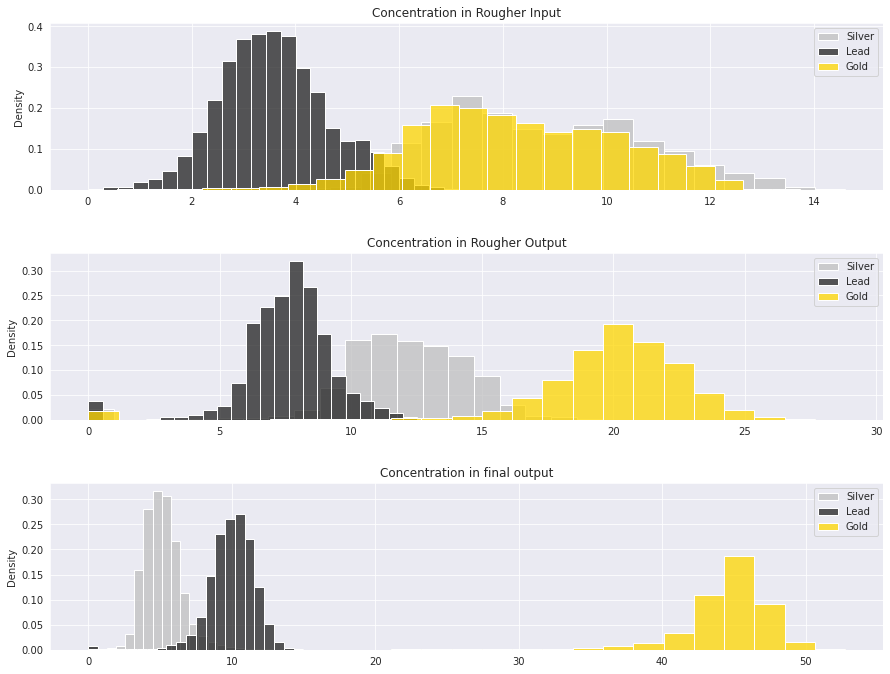

In [58]:
colors = ['silver', '#212121', 'gold']
materials = ["Silver", "Lead", "Gold"]
titles = ["Concentration in Rougher Input", "Concentration in Rougher Output", "Concentration in final output"]

fig, axs = plt.subplots(3,1, figsize = (13,10))
count = 0
for i in range(3):
  for j in range(3):
    sns.histplot(data=data_full_filt[materials_cols[count]],
                 bins=25,
                 ax=axs[i],
                 stat='density',
                 color=colors[j],
                 label=materials[j])
    count = count+1
  axs[i].set(xlabel=None)
  axs[i].set_title(titles[i])
  axs[i].legend()
fig.tight_layout(pad=3.0)
plt.show()

Cool. From the above graph we can actually see the purification process. While in the input Gold and Silver concentrations are quite the same, in the final stage we can see the gap between gold and the rest. Well, this is actually our goal! to purify the gold and separate it from the rest of the metals. Now lets look at each metal in different stages:

In [59]:
materials_cols_by_stage = ['rougher.input.feed_pb',
 'rougher.output.concentrate_pb',
 'final.output.concentrate_pb',
 'rougher.input.feed_ag',
 'rougher.output.concentrate_ag',
 'final.output.concentrate_ag',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'final.output.concentrate_au']

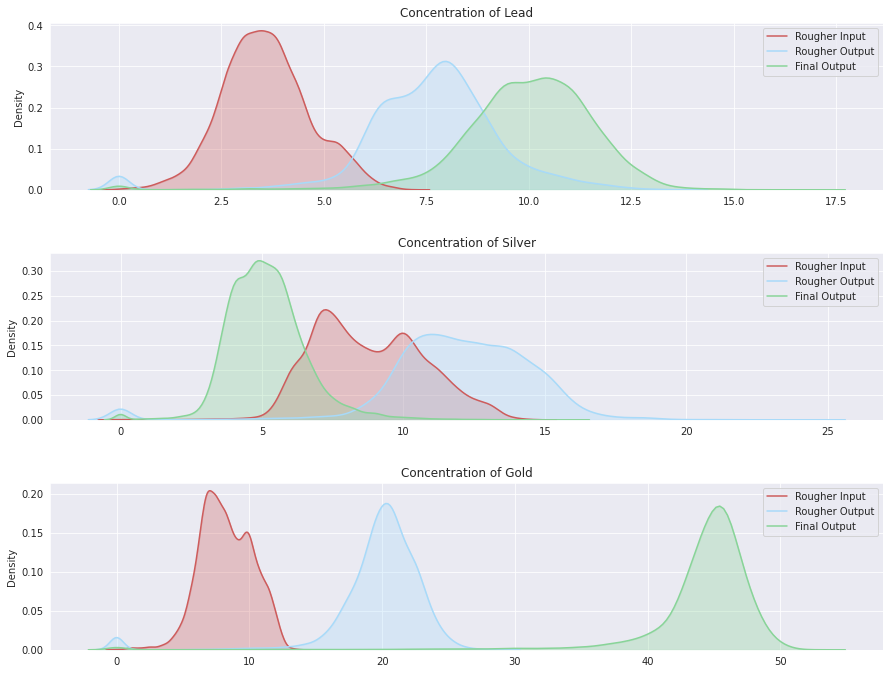

In [60]:
colors = ['#cd5c5c', '#a8daf9', '#88d498']
stages = ["Rougher Input", "Rougher Output", "Final Output"]
titles = ["Concentration of Lead", "Concentration of Silver", "Concentration of Gold"]

fig, axs = plt.subplots(3,1, figsize = (13,10))
count = 0
for i in range(3):
  for j in range(3):
    sns.distplot(data_full_filt[materials_cols_by_stage[count]],
                 hist=False,
                 ax=axs[i],
                 color=colors[j],
                 kde=True,
                 label=stages[j])
    l = axs[i].lines[j]
    x = l.get_xydata()[:,0]
    y = l.get_xydata()[:,1]
    axs[i].fill_between(x,y, color=colors[j], alpha=0.3)
    count = count+1
  axs[i].set(xlabel=None)
  axs[i].set_title(titles[i])
  axs[i].legend()
fig.tight_layout(pad=3.0)
plt.show()

Again we can see the distributions of the different metals in the different stages. But here we can see somthing strange: a pick around the zero, especialy in regard with the stage of rougher output (bright blue), but also in final output. The meaning of this pick is that there is outliers in the data. Now we can see what we undestand before. So we need to remove this outliers so that they do not interrupt the quality of our model. Since in the model we do not have the *output* features, we can remove the outliers from the input features only.

In [61]:
input_cols = [col for col in cols if 'output' not in col]
input_cols

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

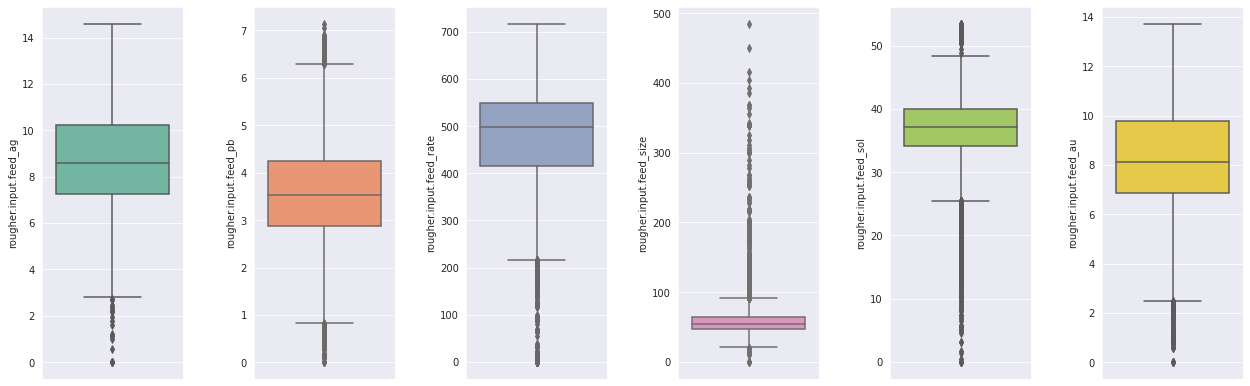

In [62]:
colors = sns.color_palette("Set2")
fig, ax = plt.subplots(1, 6, figsize=(18,6))
for i, col in enumerate(input_cols):
  sns.boxplot(data=data_full_filt, y=col, ax=ax[i], color=colors[i])
fig.tight_layout(pad=3.0)
plt.show()

Well, so in each of the columns we have outliers. Now I will write a function that ramove them all.

In [63]:
def detect_remove_outliers (data):
  '''
  This function removes outliers from the data.
  It prints the quarters, low limit and high limit.
  Returns the data.
  '''
  for col in input_cols:

    q1 = data[col].quantile(0.25)   #find quantiles
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1                             # define iqr
    low_limit = q1-(iqr*1.5)                  # outliers boundaries
    high_limit = q3 + (iqr*1.5)
    print(col, q1, q3, iqr, low_limit, high_limit)
    data = data[data[col] < high_limit]
    data = data[data[col] > low_limit]
  
  return data

In [64]:
# data_full_filt = detect_remove_outliers(data_full_filt)
# data_full_filt.shape

Now I will apply the function to data_train_filt

In [65]:
data_train_filt = detect_remove_outliers(data_train_filt)

rougher.input.feed_ag 7.132802133787153 9.918304486039961 2.7855023522528084 2.9545486054079406 14.096558014419173
rougher.input.feed_pb 2.7735592146217822 4.22016445000061 1.4466052353788275 0.603651361553541 6.390072303068851
rougher.input.feed_rate 420.70844220390927 547.1943967413313 126.485954537422 230.97951039777627 736.9233285474643
rougher.input.feed_size 48.89435751326977 64.63852421638114 15.744166703111375 25.278107458602705 88.2547742710482
rougher.input.feed_sol 34.370886646906534 39.45469854460822 5.083811897701686 26.745168800354005 47.08041639116075
rougher.input.feed_au 6.626102489314214 9.023299057772737 2.397196568458523 3.03030763662643 12.619093910460522


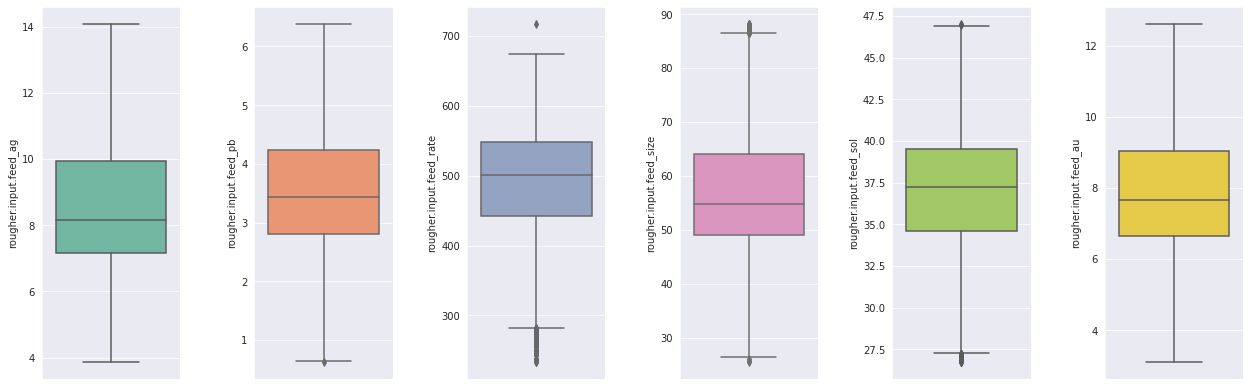

In [66]:
colors = sns.color_palette("Set2")
fig, ax = plt.subplots(1, 6, figsize=(18,6))
for i, col in enumerate(input_cols):
  sns.boxplot(data=data_train_filt, y=col, ax=ax[i], color=colors[i])
fig.tight_layout(pad=3.0)
plt.show()

Yes. looks that all of the outliers are removed indeed. Last thing for this stage is to build a correlation metrix, so that we can see which features influence the target most. I will divide the feature into 4 groups, and check correlation to the target variable:
 - .output features
 - .input features
 - air state features
 - level state features

I will check the follow assumption: Output features are correlated most with the targets. Then input features correlated in medium level with the targets. State features would have the lowest correlation with the targets.

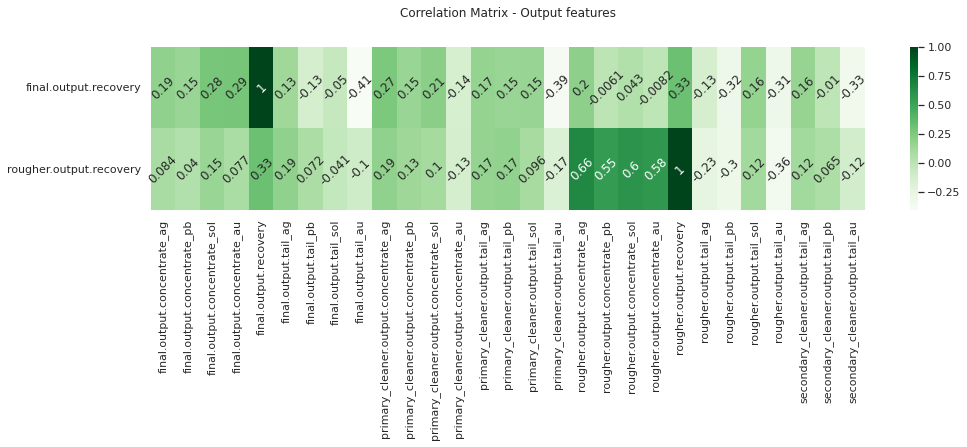

In [67]:
sns.set_theme(style="white")

corr = data_full_filt[[col for col in data_full_filt.columns if("output" in col)]].corr()  # Create the pearson correlation metrix object

fig, ax = plt.subplots(figsize=(16,3)) # create the figure

sns.heatmap(corr.loc[['final.output.recovery', 'rougher.output.recovery']], annot=True, cmap='Greens', annot_kws={'rotation':45}) # Draw the heatmap

plt.title("Correlation Matrix - Output features", pad=30)

plt.show()

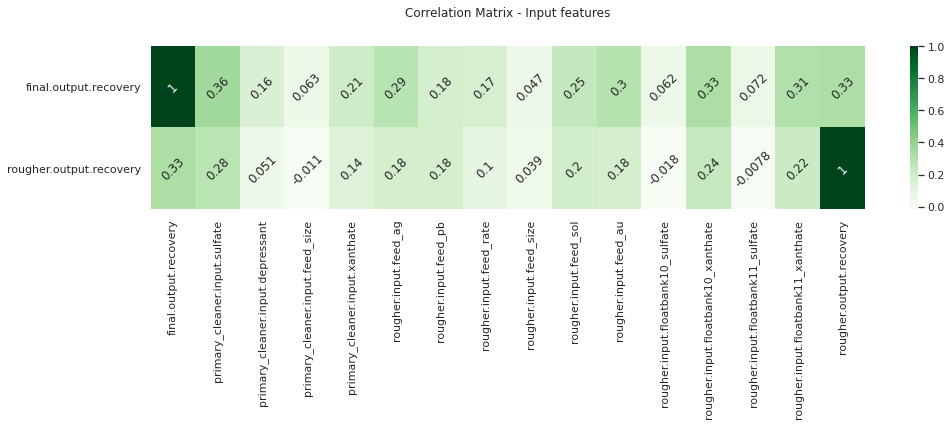

In [68]:
corr = data_full_filt[[col for col in data_full_filt.columns if("input" in col or "recovery" in col)]].corr()  # Create the pearson correlation metrix object

fig, ax = plt.subplots(figsize=(16,3)) # create the figure

sns.heatmap(corr.loc[['final.output.recovery', 'rougher.output.recovery']], annot=True, cmap='Greens', annot_kws={'rotation':45}) # Draw the heatmap

plt.title("Correlation Matrix - Input features", pad=30)

plt.show()

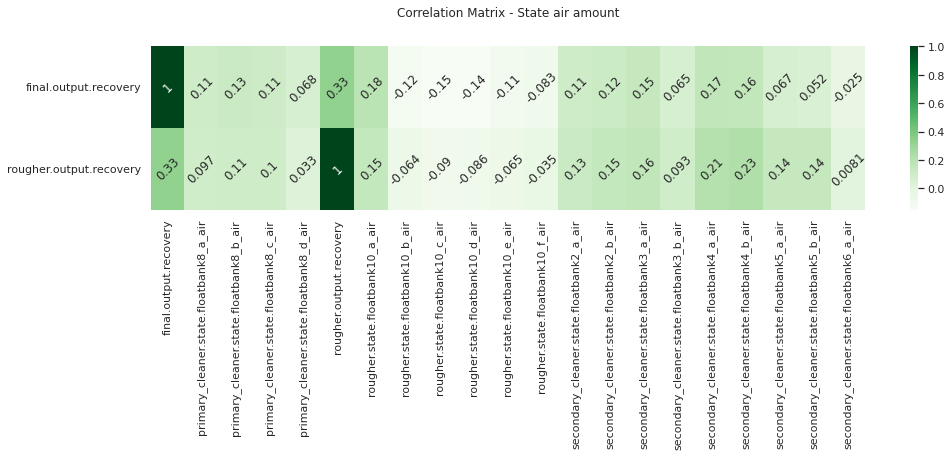

In [69]:
corr = data_full_filt[[col for col in data_full_filt.columns if(("state" in col and "air" in col) or "recovery" in col)]].corr()  # Create the pearson correlation metrix object

fig, ax = plt.subplots(figsize=(16,3)) # create the figure

sns.heatmap(corr.loc[['final.output.recovery', 'rougher.output.recovery']], annot=True, cmap='Greens', annot_kws={'rotation':45}) # Draw the heatmap

plt.title("Correlation Matrix - State air amount", pad=30)

plt.show()

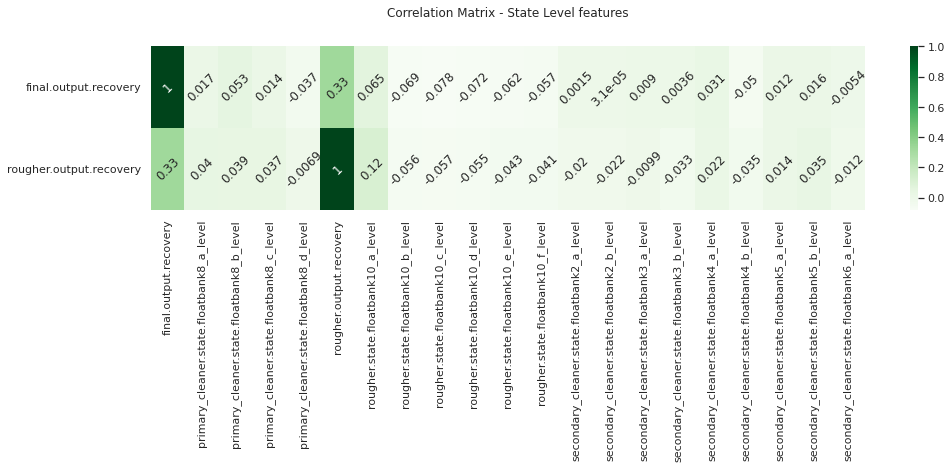

In [70]:
corr = data_full_filt[[col for col in data_full_filt.columns if(("state" in col and "level" in col) or "recovery" in col)]].corr()  # Create the pearson correlation metrix object

fig, ax = plt.subplots(figsize=(16,3)) # create the figure

sns.heatmap(corr.loc[['final.output.recovery', 'rougher.output.recovery']], annot=True, cmap='Greens', annot_kws={'rotation':45}) # Draw the heatmap

plt.title("Correlation Matrix - State Level features", pad=30)

plt.show()

What can be seen from the above heatmaps is that Output and the targets have the highest correlation, in general, then input, air, and level. It is no surprise at all that output have the highest correlation with the target, However we can not use this features in the predicting process. But what we can learn is that from the feature that we can use for prediction the input features are the most important ones.

## Build the Model

First thing to do when we come to building the model is to add targets to the test set. I will do so by combining test set with the target columns of the data full set. I will uset date as the key.

In [70]:
targets = data_full_filt[['date', 'final.output.recovery', 'rougher.output.recovery']]

In [71]:
data_test_final = data_test.merge(targets, on='date', how='inner')
data_test_final.shape

(5290, 55)

In [72]:
data_test_final.isnull().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [73]:
# drop dates in order to not interrupt the model
data_test_final = data_test_final.drop(['date'], axis=1)

And now I will filter out from the train set Features that do not appear in final test set. 

In [74]:
columns = data_test_final.columns
data_train_final = data_train_filt[columns]
data_train_final.shape

(12686, 54)

In [75]:
data_train_final.isnull().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

Looks Ok. Before building up the model itself, I will create the mxtrix according to which the models should be scored. This is the formula:

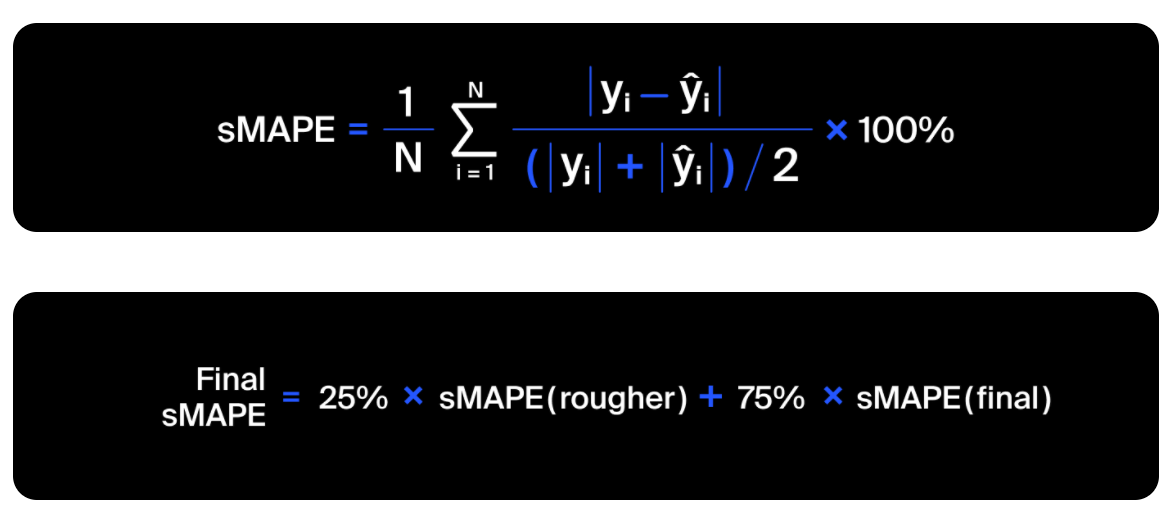

In [76]:
def smape (target, predict):
  '''
  This function calculate sMAPE score of target and predict lists according to the above formula
  '''
  nominator = 0
  denominator = 0
  for i in range(len(target)-1):
    nominator = nominator + (abs(target[i] - predict[i]) * 100) 
    denominator = denominator + ((abs(target[i]) + abs(predict[i])) / 2)
  return nominator/denominator

In [77]:
def final_smape (final_target, final_predict, rougher_target, rougher_predict):
  '''
  This function calculate final sMAPE of rougher recovery and final recovery
  '''
  smape_rougher = smape (rougher_target, rougher_predict)
  smape_final = smape (final_target, final_predict)
  final_smape = 0.25*smape_rougher + 0.75*smape_final
  return final_smape

Imidiately we will check our smape functions. But in order to do that we have to create the prediction lists. And for that we need to create a model, fit it on the train set and make predictions on validation set. 

The task is a regression task so I will use the following models:
 - Linear Regression
 - Random Forest Regressor
 - Support Vector Machine Regressor

To begin with, I will create baseline dummy model wich predict a constant value, say, the mean of the test set's target. Lets check the smape score of such a model.

### Dummy model

In [78]:
features = data_train_final.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1).reset_index(drop=True)
target_final = data_train_final['final.output.recovery'].reset_index(drop=True)
target_rougher = data_train_final['rougher.output.recovery'].reset_index(drop=True)

In [79]:
features_train, features_valid, target_final_train, target_final_valid, target_rougher_train, target_rougher_valid = train_test_split(
      features, target_final, target_rougher, test_size=0.25, random_state=12345
  )

# reset index in order not to inerrupt the smape function (which basically use the index in the score calculation)
target_final_train = target_final_train.reset_index(drop=True)
target_final_valid = target_final_valid.reset_index(drop=True)
target_rougher_train = target_rougher_train.reset_index(drop=True)
target_rougher_valid = target_rougher_valid.reset_index(drop=True)

In [80]:
fake_predictions_final = pd.Series(target_final_train.mean(), index=[i for i in range(len(target_final_valid))])
fake_predictions_rougher = pd.Series(target_rougher_train.mean(), index=[i for i in range(len(target_rougher_valid))])

In [81]:
# dictionary to store the results
smape_results = {}

In [82]:
print("score using dummy model:")
score_dummy = final_smape(target_final_valid, fake_predictions_final, target_rougher_valid, fake_predictions_rougher)
smape_results['Dummy_model'] = score_dummy
print(score_dummy)

score using dummy model:
9.486219736876789


### Run model on train + validation sets

Well, Now I will use 3 different models: Linear regression, Random forest regressor, and SVR. Firstly I will just comapre them using regular split. then I will compare them using cross validation.

In [83]:
model = LinearRegression()
model.fit(features_train, target_final_train)
predictions_final = model.predict(features_valid)
model.fit(features_train, target_rougher_train)
predictions_rougher = model.predict(features_valid)

In [84]:
print("score using Linear Regression:")
print(final_smape(target_final_valid, predictions_final, target_rougher_valid, predictions_rougher))

score using Linear Regression:
7.489417252058068


Lets try to use standard scaler:

In [85]:
scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)

In [86]:
model = LinearRegression()
model.fit(features_train, target_final_train)
predictions_final = model.predict(features_valid)
model.fit(features_train, target_rougher_train)
predictions_rougher = model.predict(features_valid)

In [87]:
print("score using Linear Regression:")
score_lr = final_smape(target_final_valid, predictions_final, target_rougher_valid, predictions_rougher)
smape_results["Linear Regression"] = score_lr
print(score_lr)

score using Linear Regression:
7.489417252058062


Well, standard scaler almost not influence the results at all. Next model to try is random forest. I will run in loop different numbers for max depth in order to optimize this parameter.

In [88]:
for i in range(1, 30, 2):

  model = RandomForestRegressor(n_estimators=20, max_depth=i, random_state=12345)
  model.fit(features_train, target_final_train)
  predictions_final = model.predict(features_valid)
  model.fit(features_train, target_rougher_train)
  predictions_rougher = model.predict(features_valid)

  print("smape score with max depth", i, ":", final_smape(target_final_valid, predictions_final, target_rougher_valid, predictions_rougher))

smape score with max depth 1 : 8.617929530321
smape score with max depth 3 : 7.6193760391158305
smape score with max depth 5 : 7.081712218258041
smape score with max depth 7 : 6.564285849055596
smape score with max depth 9 : 6.1991763316147726
smape score with max depth 11 : 5.920531519169334
smape score with max depth 13 : 5.709086237975613
smape score with max depth 15 : 5.578655290564421
smape score with max depth 17 : 5.483356050220589
smape score with max depth 19 : 5.413677944229107
smape score with max depth 21 : 5.386593854476721
smape score with max depth 23 : 5.368270023071291
smape score with max depth 25 : 5.361832383401557
smape score with max depth 27 : 5.3734342030035265
smape score with max depth 29 : 5.36185928328142


Cool, as we can see, optimal results achieved when max depth of the trees are 25. Lets try to optimize the criterion by which splits should be done. I will try MAE (instead of MSE which is the default criterion)

In [89]:
%%time
model = RandomForestRegressor(n_estimators=20, max_depth=25, criterion='mae', random_state=12345)
model.fit(features_train, target_final_train)
predictions_final = model.predict(features_valid)
model.fit(features_train, target_rougher_train)
predictions_rougher = model.predict(features_valid)

print("smape score with max depth 25 using mae score:", final_smape(target_final_valid, predictions_final, target_rougher_valid, predictions_rougher))

smape score with max depth 25 using mae score: 5.460485376029197
CPU times: user 10min, sys: 430 ms, total: 10min 1s
Wall time: 9min 58s


Well, results are quite same as before, and time of running is around 10(!) minutes. Next I will use the mse score. Last thing to do when using Random Forest is to enlarge the number of estimators.

In [90]:
model = RandomForestRegressor(n_estimators=100, max_depth=25, random_state=12345)
model.fit(features_train, target_final_train)
predictions_final = model.predict(features_valid)
model.fit(features_train, target_rougher_train)
predictions_rougher = model.predict(features_valid)

score_rf = final_smape(target_final_valid, predictions_final, target_rougher_valid, predictions_rougher)
smape_results['Random Forest'] = score_rf
print("smape score with max depth 25 using mae score:", score_rf)

smape score with max depth 25 using mae score: 5.169471388666701


Last model to try is Support Vector Machine Regressor

In [91]:
model = SVR()
model.fit(features_train, target_final_train)
predictions_final = model.predict(features_valid)
model.fit(features_train, target_rougher_train)
predictions_rougher = model.predict(features_valid)

score_svr = final_smape(target_final_valid, predictions_final, target_rougher_valid, predictions_rougher)
smape_results['SVR'] = score_svr
print("smape score using svr:", score_svr)

smape score using svr: 5.850307704137928


In [92]:
pd.DataFrame(smape_results, index =['smape'])

,Dummy_model,Linear Regression,Random Forest,SVR
smape,9.48622,7.489417,5.169471,5.850308


Best results achieved using random forest. Now I will check which is the best model using cross validation. 

### Cross Validation

In [93]:
model = LinearRegression()
predictions_final = cross_val_predict(model, features, target_final, cv=5)

In [94]:
predictions_rougher = cross_val_predict(model, features, target_rougher, cv=5)

In [95]:
print("final sMAPE score using Linear Regression:")
score_lr = final_smape(target_final, predictions_final, target_rougher, predictions_rougher)
smape_results['Linear Regression'] = score_lr
score_lr

final sMAPE score using Linear Regression:


10.41652528834544

In [96]:
model = RandomForestRegressor(n_estimators = 100, max_depth=25, random_state=12345)

In [97]:
predictions_final = cross_val_predict(model, features, target_final, cv=5)

In [98]:
predictions_rougher = cross_val_predict(model, features, target_rougher, cv=5)

In [99]:
print("final sMAPE score using Random Forest Regressor:")
score_rf = final_smape(target_final, predictions_final, target_rougher, predictions_rougher)
smape_results['Random Forest'] = score_rf
score_rf

final sMAPE score using Random Forest Regressor:


9.837385412523894

In [100]:
model = SVR()

In [101]:
predictions_final = cross_val_predict(model, features, target_final, cv=5)

In [102]:
predictions_rougher = cross_val_predict(model, features, target_rougher, cv=5)

In [103]:
print("final sMAPE score using Support Vector Machine regressor:")
score_svr = final_smape(target_final, predictions_final, target_rougher, predictions_rougher)
smape_results['SVR'] = score_svr
score_svr

final sMAPE score using Support Vector Machine regressor:


8.92306053587214

In [104]:
pd.DataFrame(smape_results, index =['smape'])

,Dummy_model,Linear Regression,Random Forest,SVR
smape,9.48622,10.416525,9.837385,8.923061


Well, So best results achieved using SVR. Lets train the model now on the entire train set, and check the results on test set!

### Make Predictions on Test Set

In [105]:
features_test = data_test_final.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target_test_final = data_test_final['final.output.recovery']
target_test_rougher = data_test_final['rougher.output.recovery']

<div class="alert alert-danger">
<b>Reviewer's comment</b>
	  
I'm not sure how this train set is different from the train set used before. Could you explain?
	  
</div>

In [111]:
# apply standard scaler

scaler = StandardScaler()

features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [ ]:
model = SVR()

In [112]:
model.fit(features, target_final)
predictions_final = model.predict(features_test)
predictions_final

array([69.67929354, 69.54568025, 69.95824206, ..., 69.75725993,
       72.77278631, 73.00290033])

In [113]:
model.fit(features, target_rougher)
predictions_rougher = model.predict(features_test)
predictions_rougher

array([88.0962234 , 85.12359889, 81.93625024, ..., 88.8683779 ,
       92.43123275, 92.32104274])

In [114]:
print("final sMAPE score on test set using Random Forest:")
final_smape(target_test_final, predictions_final, target_test_rougher, predictions_rougher)

final sMAPE score on test set using Random Forest:


9.243889915010115

Final result on test set using Support Vector Machine regressor is 9.24. It is not so good comparing the resutlts we achieved using dummy model, but we have to notice that the test is "unseen" not-process data - anomalies did not removed from test set.

## General Conclusion

In this project I try to predict recovery rates of gold when processing it through some stages.

In the beginning I pre-process the data, remove and fill missing values, then I have done EDA and remove outliers from the data, in order to prepare it for modeling.

I use 3 different types of models to check quality of prediction: Linear Regression, Random Forest and SVR. The score I used is the sMAPE which calculate the gap between actual target and prediction divided my the mean of target and prediction. 

What I got is that SVR perform best on the validation sets (with score of 8.92 using CV and 5.85 using random split) So I use SVR to make prediction over the test set. sMAPE score over the test set was 9.24.

<div class="alert alert-danger">
<b>Reviewer's comment</b>
	  
The modeling section is not bad, but there are a couple of problems:
    
1. Due to a problem with smape function, the results are based on one example, so are not reliable.
2. You need to add some simple baseline, for example a constant model always predicting the train targets' mean or median (it's convenient to use [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) for such baselines)
3. It is required to consider at least two different sets of hyperparameters for at least one model
	  
</div>